## Comparing fitted model to TNG100

In [1]:
#imports from FitComparison_3panelPlot
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

#from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2018
from astropy.cosmology import z_at_value
from astropy.table import Table

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import paths
import init_values as In

In [30]:
data_dir    =  str(paths.data) +'/'
save_loc = str(paths.figures) + '/'
rate_file_name = 'Rate_info_TNG100.h5'
COMPASfilename = 'COMPAS_Output_wWeights.h5'
TNGfilename = 'SFRMetallicityFromGasTNG100-1.hdf5'
fit_param_filename = 'test_best_fit_parameters_TNG100.txt'
Rboxval = 75 #35 for TNG50, 75 for 100, 205 for 300

In [3]:
#define chirp mass function
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

In [4]:
#values
In.init()
Zsun = 0.014 # Solar metallicity
mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+fit_param_filename,unpack=True, delimiter=',')
obs_SFRD = []
min_logZ  = -12.0
max_logZ  = 0.0
step_logZ = 0.01
add_TNG = False, 
plot_dPdZcontours = True
neijssel_fit = True
FITkleur="crest"
dPdZ_text = ''
SFR_text = ''
tmin = 0.0
tmax = 13.7
mu_0=mu0_best
mu_z=muz_best
alpha = alpha0_best
omega_0=omega0_best
omega_z =omegaz_best
a=sf_a_best
b=sf_b_best
c=sf_c_best
d=sf_d_best

In [5]:
if len(obs_SFRD) == 0:
            print('Using original TNG')
            with h5.File(data_dir+TNGfilename, "r") as f:
                MetalBins         = f["MetalBins"][:]
                Obs_Lookbacktimes = f["Lookbacktimes"][:]
                BoxSfr            = f["Sfr"][:]
                Obs_redshifts         = f["Redshifts"][:]

            # Convert SFR from sfr/box to sfr Mpc-3
            littleh = 0.6774
            Rbox    = Rboxval/littleh
            Obs_cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
            Obs_cosmic_SFR = Obs_cosmic_SFR.value
            Obs_cosmic_SFR = Obs_cosmic_SFR.T

            ##########################################
            # "observed" TNG metallicities that we use for our calculations
            ##########################################
            Obs_center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
            log_obs_metallicities = np.log10(MetalBins)
            step_obs_logZ         = np.diff(log_obs_metallicities)[0]
            
            print('step_obs_logZ',step_obs_logZ)
            print('np.amax(Obs_cosmic_SFR/dlogZ)', np.amax(Obs_cosmic_SFR/step_obs_logZ))
else:
            print('Using interpolated TNG')
            Obs_Lookbacktimes = obs_lookback
            Obs_center_Zbin   = obs_metal
            Obs_cosmic_SFR    = obs_SFRD

Using original TNG
step_obs_logZ 0.16666666666666607
np.amax(Obs_cosmic_SFR/dlogZ) 0.08268044129983945


In [6]:
# The new Z-dep SFRD and Neijssel + 2019 can both be plotted at an arbitrarily 
# high resolution in both redshift and metallicity. We'll use the following:
high_res_metals    = Obs_center_Zbin 
high_res_redshifts = np.arange(0, 10.1, 0.05)
#Convert redshift to lookback time
high_res_t         = cosmo.lookback_time(high_res_redshifts)

# PLot the following contours for both models:
levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,5e-2,1e-1]

In [7]:
fit_values_string = r'$\mathrm{Cosmic \ metallicity \ dist.}$'+'\n'+\
                        r'$\mu_0=%s,$'%(np.round(mu_0,3)) +'\n'+\
                        r'$\mu_z=%s,$'%(np.round(mu_z,3)) +'\n'+\
                        r'$\omega_0=%s,$'%(np.round(omega_0,3)) +'\n'\
                        r'$\omega_z=%s,$'%(np.round(omega_z,3)) +'\n'\
                        r'$a_0=%s$'%(np.round(alpha,3))

SFR_fit_string = r'$\mathrm{Star \ formation \ rate}$'+'\n'+\
                         '$a=%s,$'%(np.round(a,3)) +'\n'+\
                         '$b=%s,$'%(np.round(b,3)) +'\n'+\
                         '$c=%s,$'%(np.round(c,3)) +'\n'\
                         '$d=%s,$'%(np.round(d,3))

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_89328/2654949694.py:55: UserWarning: Log scale: values of z <= 0 have been masked
  cs_N = ax.contour(high_res_t, high_res_metals/Zsun, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,


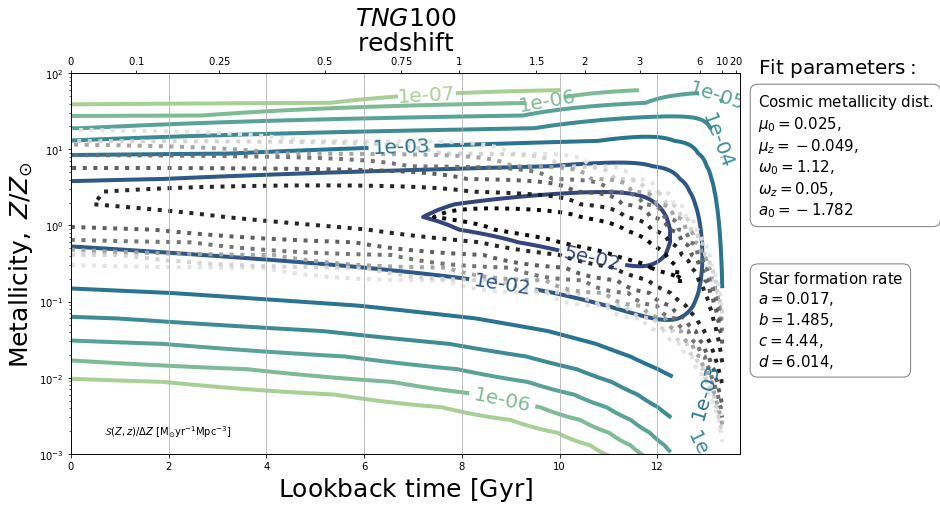

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))

if add_TNG==True:
    #add TNG contours
    tng_color = sns.light_palette("#fe875d", as_cmap=True, n_colors = 7) # construct smooth cmap from one colour
    TNG = ax.pcolormesh(Obs_Lookbacktimes, Obs_center_Zbin/Zsun, Obs_cosmic_SFR/step_obs_logZ, 
                                rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                                cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
    #cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height]
    cbaxes1 = fig.add_axes([0.12, 0.0, 0.8, 0.03]) #[left, bottom, width, height]
    cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG100 \ SFRD/\Delta Z \ [M_{\odot} yr^{-1} Mpc^{-3}]}$", 
                 orientation='horizontal')

#Plot dPdZ contours
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                            Z_SFRD.skew_metallicity_distribution(high_res_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                          omega_0=omega_0, omega_z =omega_z, 
                                                          metals = high_res_metals)
# Get the SFR
sfr        = Z_SFRD.Madau_Dickinson2014(high_res_redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
model_SFRD = (sfr* dPdlogZ.T).value

# Plot the contours of your Z-dep SFRD
COMPAS_cmap = sns.color_palette('crest', as_cmap=True)
cs = ax.contour(high_res_t, high_res_metals/Zsun, model_SFRD/step_logZ, levels, linewidths=4, cmap=COMPAS_cmap,
                             locator=ticker.LogLocator(), alpha = 0.95, zorder=0)
ax.clabel(cs,inline=1,fontsize=20, levels = levels, use_clabeltext=True, fmt = '%.0e')


# print all fit values on side of plot
ax.text(0.92, 0.88, '$\mathrm{Fit \ parameters:}$',  fontsize=20, transform=plt.gcf().transFigure)
# dPdZ
ax.text(0.92, 0.6, fit_values_string, fontsize=15, transform=plt.gcf().transFigure,
                   bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
# SFR
ax.text(0.92, 0.3, SFR_fit_string, fontsize=15, transform=plt.gcf().transFigure,
                   bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))

####

# Neijssel 2019
# Get the data for Z-dep SFRD

# Get dPdZ   
neijssel_dPdlogZ, neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                            Z_SFRD.skew_metallicity_distribution(high_res_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                                min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=high_res_metals)
# Get the SFR Neijssel et al 2019:
neijssel_sfr = Z_SFRD.Madau_Dickinson2014(high_res_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
Neijssel_SFRDzZ = (neijssel_sfr* neijssel_dPdlogZ.T).value

greys = cm.get_cmap('Greys')
greys = greys(np.linspace(0.2,1,10)) # Don't start the cmap in white
cs_N = ax.contour(high_res_t, high_res_metals/Zsun, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,
                              cmap=ListedColormap(greys),locator=ticker.LogLocator())

#####

# Axes formatting for top panel
ax.text(0.05, 0.05, r"$ \mathcal{S}(Z,z)/ \Delta Z \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", transform=ax.transAxes)
ax.xaxis.grid(5) # vertical lines
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 25)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize = 25)
ax.set_title(r'$TNG100$', fontsize=25)

# Add redshift axis
ax2 = ax.twiny()
 
# Annotate the tick labels
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10, 20]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 25)

#Make sure top and bottom axis are lined up (have same limits)
ax.set_xlim(tmin, tmax)
ax2.set_xlim(tmin, tmax)

ax.set_ylim(1e-3, 1e2)

fig.savefig('SFRDcontours_TNG100.pdf', bbox_inches='tight')

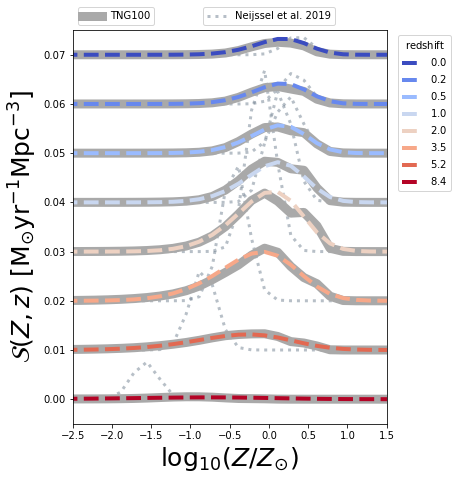

In [9]:
#Plot the bottom two panels from fig 1

fig = plt.figure(figsize = (15,15))
gs = gridspec.GridSpec(10, 8)
gs.update(wspace=0.0, hspace=0.5)
ax_metals = plt.subplot(gs[5:, :3])

#Get Z dependent SFRD at same resolution as the TNG
low_res_dPdlogZ, low_res_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      omega_0=omega_0, omega_z =omega_z, min_logZ  =min_logZ, max_logZ  =max_logZ, step_logZ = step_logZ,
                                                      metals = Obs_center_Zbin)
#  SFR
low_res_sfr = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
low_res_model_SFRD = (low_res_sfr* (low_res_dPdlogZ * step_logZ ).T).value

# Neijssel +2019
#  dPdZ   
low_res_neijssel_dPdlogZ, low_res_neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=Obs_center_Zbin)
#  SFR Neijssel et al 2019:
low_res_neijssel_sfr    = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
low_res_Neijssel_SFRDzZ = (low_res_neijssel_sfr*(low_res_neijssel_dPdlogZ*neijssel_step_logZ).T).value

#Left panel plot
redshifts_to_plot = [0,0.2, 0.5, 1, 2.0, 3.49, 5.23, 8.45]
redshift_indces   = [np.where(np.round(Obs_redshifts,2) == x)[0][0] for x in redshifts_to_plot]
colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redshift_indces))) #3rd num is the number of colours
LAB = 'TNG100'
plot_lines = []

# Plot a set of redshifts with offset
for i, redshift_i in enumerate(redshift_indces):
    if i != 0:
        LAB = None
    # The offset on the y-axis 
    shift_step = (len(redshift_indces)-1)*0.01 - 0.01*i 
    ######################################
    # Observed: TNG data
    ax_metals.plot(np.log10(Obs_center_Zbin/Zsun), Obs_cosmic_SFR[:,redshift_i] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

    ######################################
    # Model: new SFRD
    l = ax_metals.plot(np.log10(low_res_metallicities/Zsun), low_res_model_SFRD[:,redshift_i] + shift_step,
                           lw = 4, ls = '--', c = colors[i], label = "$z=%s$"%(np.round(Obs_redshifts[redshift_i], 1)) ) 
    
    ax_metals.plot(np.log10(low_res_metallicities/Zsun), low_res_Neijssel_SFRDzZ[:,redshift_i] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)  
    
    plot_lines.append([l])

# Plotvalues for bottom left panel
######################################
lines = ax_metals.get_lines()
legend1 = ax_metals.legend(lines[0:1], ['TNG100','TNG100'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
ax_metals.add_artist(legend1)
        
legend2 = ax_metals.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
ax_metals.add_artist(legend2)
        
legend3 = ax_metals.legend(lines[1::3], ["$%s$"%(np.round(Obs_redshifts[redshift_i], 1)) for redshift_i in redshift_indces],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\mathrm{redshift}$')
        
ax_metals.set_xlabel(r'$\log_{10}(Z/Z_{\odot})$', size =25)
ax_metals.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)
ax_metals.set_ylim(-0.005, 0.075)
ax_metals.set_xlim(-2.5, 1.5)#-0.5)

fig.savefig(paths.figures /'SFRDredshiftslices_TNG100.pdf', bbox_inches='tight')

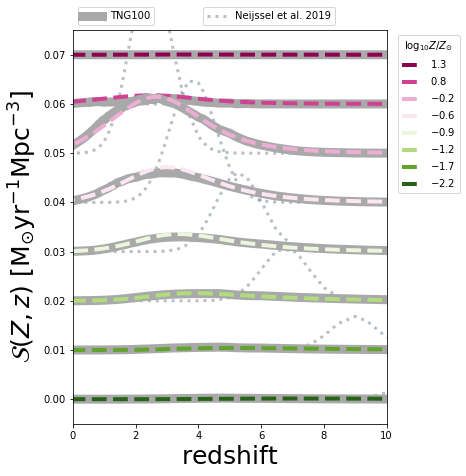

In [10]:
#Plot the bottom right panel from fig 1

fig = plt.figure(figsize = (15,15))
gs = gridspec.GridSpec(10, 8)
gs.update(wspace=0.0, hspace=0.5)
ax_redshifts = plt.subplot(gs[5:, :3])

#Get Z dependent SFRD at same resolution as the TNG
low_res_dPdlogZ, low_res_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      omega_0=omega_0, omega_z =omega_z, min_logZ  =min_logZ, max_logZ  =max_logZ, step_logZ = step_logZ,
                                                      metals = Obs_center_Zbin)
#  SFR
low_res_sfr = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
low_res_model_SFRD = (low_res_sfr* (low_res_dPdlogZ * step_logZ ).T).value

# Neijssel +2019
#  dPdZ   
low_res_neijssel_dPdlogZ, low_res_neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=Obs_center_Zbin)
#  SFR Neijssel et al 2019:
low_res_neijssel_sfr    = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
low_res_Neijssel_SFRDzZ = (low_res_neijssel_sfr*(low_res_neijssel_dPdlogZ*neijssel_step_logZ).T).value


#######

#Right panel plot
logmetals_to_plot = [-0.58, -1.08, -2.08, -2.41, -2.74, -3.08, -3.58, -4.08]
metal_indices   = [np.where(np.round(np.log10(Obs_center_Zbin),2) == x)[0][0] for x in logmetals_to_plot]
colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metal_indices))) #3rd num is the number of colours
LAB = 'TNG100'
plot_lines = []

# Plot a set of redshifts with offset
for i, metal_i in enumerate(metal_indices):
    if i != 0:
        LAB = None
    # The offset on the y-axis 
    shift_step = (len(metal_indices)-1)*0.01 - 0.01*i
    ######################################
    # Observed: TNG data
    ax_redshifts.plot(Obs_redshifts, Obs_cosmic_SFR[metal_i,:] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

    ######################################
    # Model: new SFRD
    l = ax_redshifts.plot(Obs_redshifts, low_res_model_SFRD[metal_i,:] + shift_step,
                           lw = 4, ls = '--', c = colors[i] )    
    plot_lines.append([l])
    
    ax_redshifts.plot(Obs_redshifts, low_res_Neijssel_SFRDzZ[metal_i,:] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)
    
    plot_lines.append([l])

# Plotvalues for bottom left panel
######################################
lines = ax_redshifts.get_lines()
legend1 = ax_redshifts.legend(lines[0:1], ['TNG100','TNG100'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
ax_redshifts.add_artist(legend1)
        
legend2 = ax_redshifts.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
ax_redshifts.add_artist(legend2)
        
legend3 = ax_redshifts.legend(lines[1::3], ["$%s$"%(np.round(np.log10(Obs_center_Zbin[metal_i]/Zsun), 1)) for metal_i in metal_indices],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\log_{10}Z/Z_{\rm{\odot}}$')
        
ax_redshifts.set_xlabel(r'$\mathrm{redshift}$', size =25)
ax_redshifts.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)
        
ax_redshifts.set_xlim(0, 10)
ax_redshifts.set_ylim(-0.005, 0.075)

fig.savefig(paths.figures /'SFRDmetallicitylices_TNG100.pdf', bbox_inches='tight')

## Comparing SFRD(z)

In [11]:
def powerlaw_fit_Chruslinska21(z_bounds= [0,1.0,1.8,4.0,7.0,8.8, 10.0], 
                                   kappa_list = [2.3822, 2.2105, -1.2278,-2.4769, -12.5280, 0],
                                   A_list = [0.0248, 0.028, 0.964, 7.2, 8.6*10**9, 0.00328]):
        """
        Powerlaw approximation from Chruslinska +2021 (Fig. 11 and tables 3 and B2)
        Default values are upper edge of Cosmic SFH – SB: B18/C17 == Thick brown line in fig. 11
        """
        redshifts, SFRD = [], []
        for i in range(len(z_bounds) -1):
            z    = np.linspace(z_bounds[i], z_bounds[i+1], num = 20)
            z    = (z[:-1] + z[1:])/2.
            redshifts.append(z)
            
            vals = A_list[i] * (1 + z)**kappa_list[i]
            SFRD.append(A_list[i] * (1 + z)**kappa_list[i])
            
        redshifts = np.array(redshifts).flatten()
        SFRD      = np.array(SFRD).flatten()
        
        return redshifts, SFRD # Msun /yr /Mpc^3

In [12]:
def plot_SFR(sf_a = 0.017, sf_b = 1.481, sf_c = 4.452,  sf_d = 5.913, show_legend = True,
                 redshift_list  = np.linspace(0,15, num=100), x_redshift = True, show_powerlaw_fit = False,
                 tmin=0.0, tmax = 13.7, readTNG=False):
        ########################################################
        # Start plotting
        fig, ax = plt.subplots(figsize=(10,8))

        if x_redshift:
            x1  = redshift_list
        else:
            x1 = cosmo.lookback_time(redshift_list)

    #     #default M&D 14
    #     # Because MD14 was computed using a salpeter IMF, you need to correct the SFRD!
    #     salpeter_to_kroupa = (1./1.55) 
    #     ax.plot(x1, salpeter_to_kroupa*Z_SFRD.Madau_Dickinson2014(redshift_list), 
    #              label = 'Madau and Dickinson 2014\n $a=%.3f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.7,2.9,5.6)
    #              , c = 'royalblue', ls = '--',lw=2)

        #default Madau & Fragos 17
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
                 label = 'Madau and Fragos 2017'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
                 , c = 'grey', ls = ':',lw=6)

    #     #default Coen
    #     ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
    #              label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
    #              , c = '#aacfdd', lw=5, ls = '--')

        #########
        # Approximate max SFRD
        if show_powerlaw_fit:
            # --> Thick brown line in Fig. 11 Chruslinska + 2021 (models: 30*f14SBBiC)
            upper_redshifts, upper_SFRD = powerlaw_fit_Chruslinska21()
            if x_redshift:
                upper_x = upper_redshifts
            else:
                upper_x = cosmo.lookback_time(upper_redshifts)
            ax.plot(upper_x, upper_SFRD, 
                 # label = r'$\rm{Max \ SFR, \ Chruslinska \ et \ al. \ 2021: (SB: \ B18/C17)}$',
                 label = 'Max  SFR,  Chruslinska  et  al.  2021: (SB:  B18/C17)',
                    c = 'brown', lw=5, ls = '-.')

        #Resembling thick brown line in Fig. 11 Chruslinska + 2021
        a_max, b_max, c_max, d_max = 0.025,2.6,3.3,5.9 #2.5,2.9,4.5 
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=a_max, b=b_max, c=c_max, d=d_max), 
                 label = 'Approx. to  upper limit:'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (a_max, b_max, c_max, d_max)
                 , c = '#356288', lw=5, ls = '-')

        # BEST FIT
        try:
            y_vals = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a, b=sf_b, c=sf_c,  d=sf_d)
            ax.plot(x1, y_vals,label = 'Using best fit parameters (fiducial)'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a,sf_b,sf_c, sf_d), 
                     c = '#fe1100', lw=5, ls = '--', zorder =10)
            print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
        except:
            print('you probably havent run the optimzation yet..')



        ######################################
        # read TNG data
        ######################################
        with h5.File(data_dir+TNGfilename, "r") as f:
            MetalBins     = f["MetalBins"][:]
            Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]
            Redshifts     = f["Redshifts"][:]
        # Convert SFR from sfr/box to sfr Mpc-3
        littleh  = 0.6774
        Rbox     = Rboxval/littleh
        TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
        TNG_SFRD = TNG_SFRD.value
        # the last value of Lookbacktimes = 0, which is problematic for z calculation
        redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in Lookbacktimes[:-1]] 
        redshifts_TNG.append(0) # put redshift zero back at the end
        redshifts_TNG = np.array(redshifts_TNG)
        if readTNG == True:
            redshifts_TNG = Redshifts
        redshifts_TNG_inc = redshifts_TNG[::-1]
        ##########################################
        # "observed" TNG SFR(z)
        ##########################################
        if x_redshift:
            xobs  = redshifts_TNG
            #xobs2 = Redshifts
        else:
            xobs = Lookbacktimes

        ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG100', c = '#fe875d', lw=6)

        ##########################################
        # Checking normalization of what I will fit
        ##########################################################################
        center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
        sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        # Get dPdZ 
        dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

        if x_redshift:
            x  = redshifts_TNG_inc
        else:
            x = cosmo.lookback_time(redshifts_TNG_inc)

        # For each redshift in the TNG data:
        for redshift_i in range(len(redshifts_TNG_inc)):
            SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
            #plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
            #
        ##########################################################################


        #### Age Universe Axis ####
        #ax2 = ax.twiny()

        if x_redshift:
            ###################
            #Plotvalues
            ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)

            # Find loockback location for each of our redshifts
            # redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            redshift_tick_list = [0, 2, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            # And annotate the tick labels :)
            #ax2.set_xticks([z for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            #ax2.set_xlabel('Lookback time [Gyr]', fontsize = 30)

        else:
            ###################
            #Plotvalues
            # ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            ax.set_xlabel('Lookback time [Gyr]', fontsize = 30)
            
            redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
            # Find loockback location for each of our ages
            z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

            # And annotate the tick labels :)
            #ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)
            #ax2.set_xlabel('redshift', fontsize = 30)


        ##########################################################################
        ax.xaxis.grid(5) # vertical lines
        # Make sure top and bottom axis are lined up (have same limmits)
        ax.set_xlim(tmin, tmax)
        #ax2.set_xlim(tmin, tmax)
        logy = True
        if logy:
            plt.yscale('log')
        ax.set_ylabel(r'$dM/dt dV_c$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
        ax.yaxis.set_tick_params(labelsize=24)
        ax.set_ylim(1e-3, 1.)
        if show_legend:
            ax.legend()
        if x_redshift:
            print('saving here', save_loc + 'SFR_redshift'+'.pdf')
            plt.savefig(save_loc + 'SFR_redshift_TNG100'+'.pdf',  bbox_inches='tight')
        else:
            print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
            plt.savefig(save_loc + 'SFR_tlookback_TNG100'+'.pdf',  bbox_inches='tight')
        
        # plt.show()

max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr
saving here /Users/sashalvna/Research/Fit_SFRD_TNG/figures/SFR_tlookback.pdf


/Users/sashalvna/Research/Fit_SFRD_TNG/get_ZdepSFRD.py:117: RuntimeWarning: invalid value encountered in divide
  dPdlogZ = dPdlogZ /norm[:,np.newaxis]


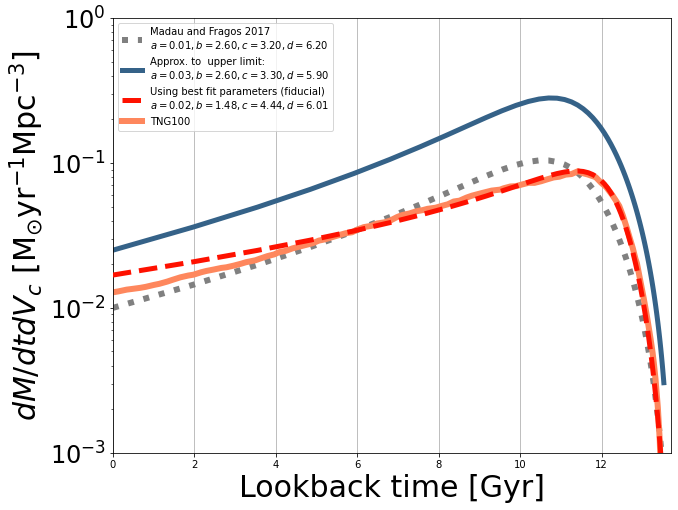

In [13]:
plot_SFR(sf_a = a, sf_b = b, sf_c = c,  sf_d = d,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275
saving here /Users/sashalvna/Research/Fit_SFRD_TNG/figures/SFR_redshift.pdf


/Users/sashalvna/Research/Fit_SFRD_TNG/get_ZdepSFRD.py:117: RuntimeWarning: invalid value encountered in divide
  dPdlogZ = dPdlogZ /norm[:,np.newaxis]


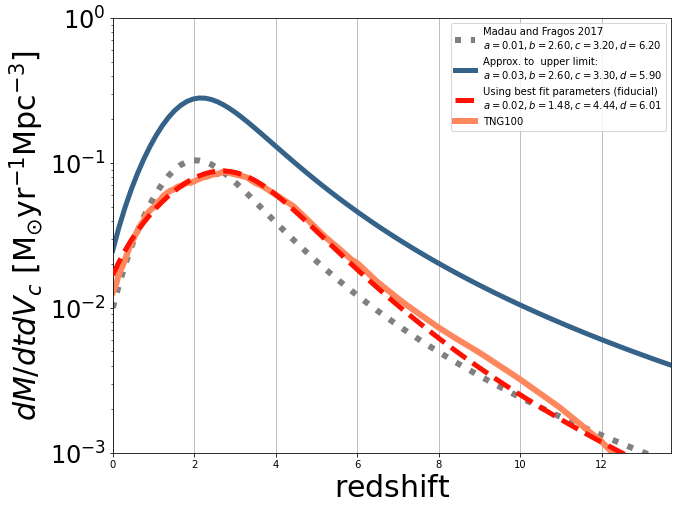

In [14]:
plot_SFR(sf_a = a, sf_b = b, sf_c = c,  sf_d = d,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7)

## Stable BH primary mass distribution for variations of SFRD(Z, z) 

In [15]:
import matplotlib
matplotlib.use('Agg')

import seaborn as sns
from scipy import stats

import json
import argparse
import gc

# Custom scripts
import MassDistHelperFunctions as mfunc
import Plot_Mass_distributions as pltmass

In [16]:
# plot setttings
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
from matplotlib import rc

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [17]:
#check rate file names
path = data_dir+'/'+rate_file_name
file = h5.File(path, 'r')
list(file.keys())

['Rates_mu00.007_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned',
 'Rates_mu00.007_muz-0.049_alpha-1.786_sigma01.123_sigmaz0.049_a0.017_b1.487_c4.443_d5.946_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.782_sigma00.7_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.01_b2.6_c3.2_d6.2_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.03_b2.6_c3.3_d5.9_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.0_a0.017_b1.485_c4.44_d6.014_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.1_a0.017_b1.485_c4.44_d6.014_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.782_sigma02.0_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned',
 'Rates_mu00.025_muz-0.049_alpha-1.786_sigma00.7_sigmaz0.049_a0.017_b1.487_c4.443_d5.946_zBinned',
 'Rates_mu00.025_muz-0.049_alpha

plotting LIGO
Reading  /Users/sashalvna/Research/Fit_SFRD_TNG/data//COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
nplot 0 

rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma00.7_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $  len(merging_BBH)= 449453  Rate =  6.33446903372662  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 449453  Rate =  16.95553776848153  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma02.0_sigmaz0.05_a0.017_b1.485_c4.44_d6

m 1.2321657267983077 [3.89936714] [1.2200611]

m 0.4149797567505745 [1.36262122] [0.41269591]

m 0.020686012306996945 [0.06866135] [0.01937152]



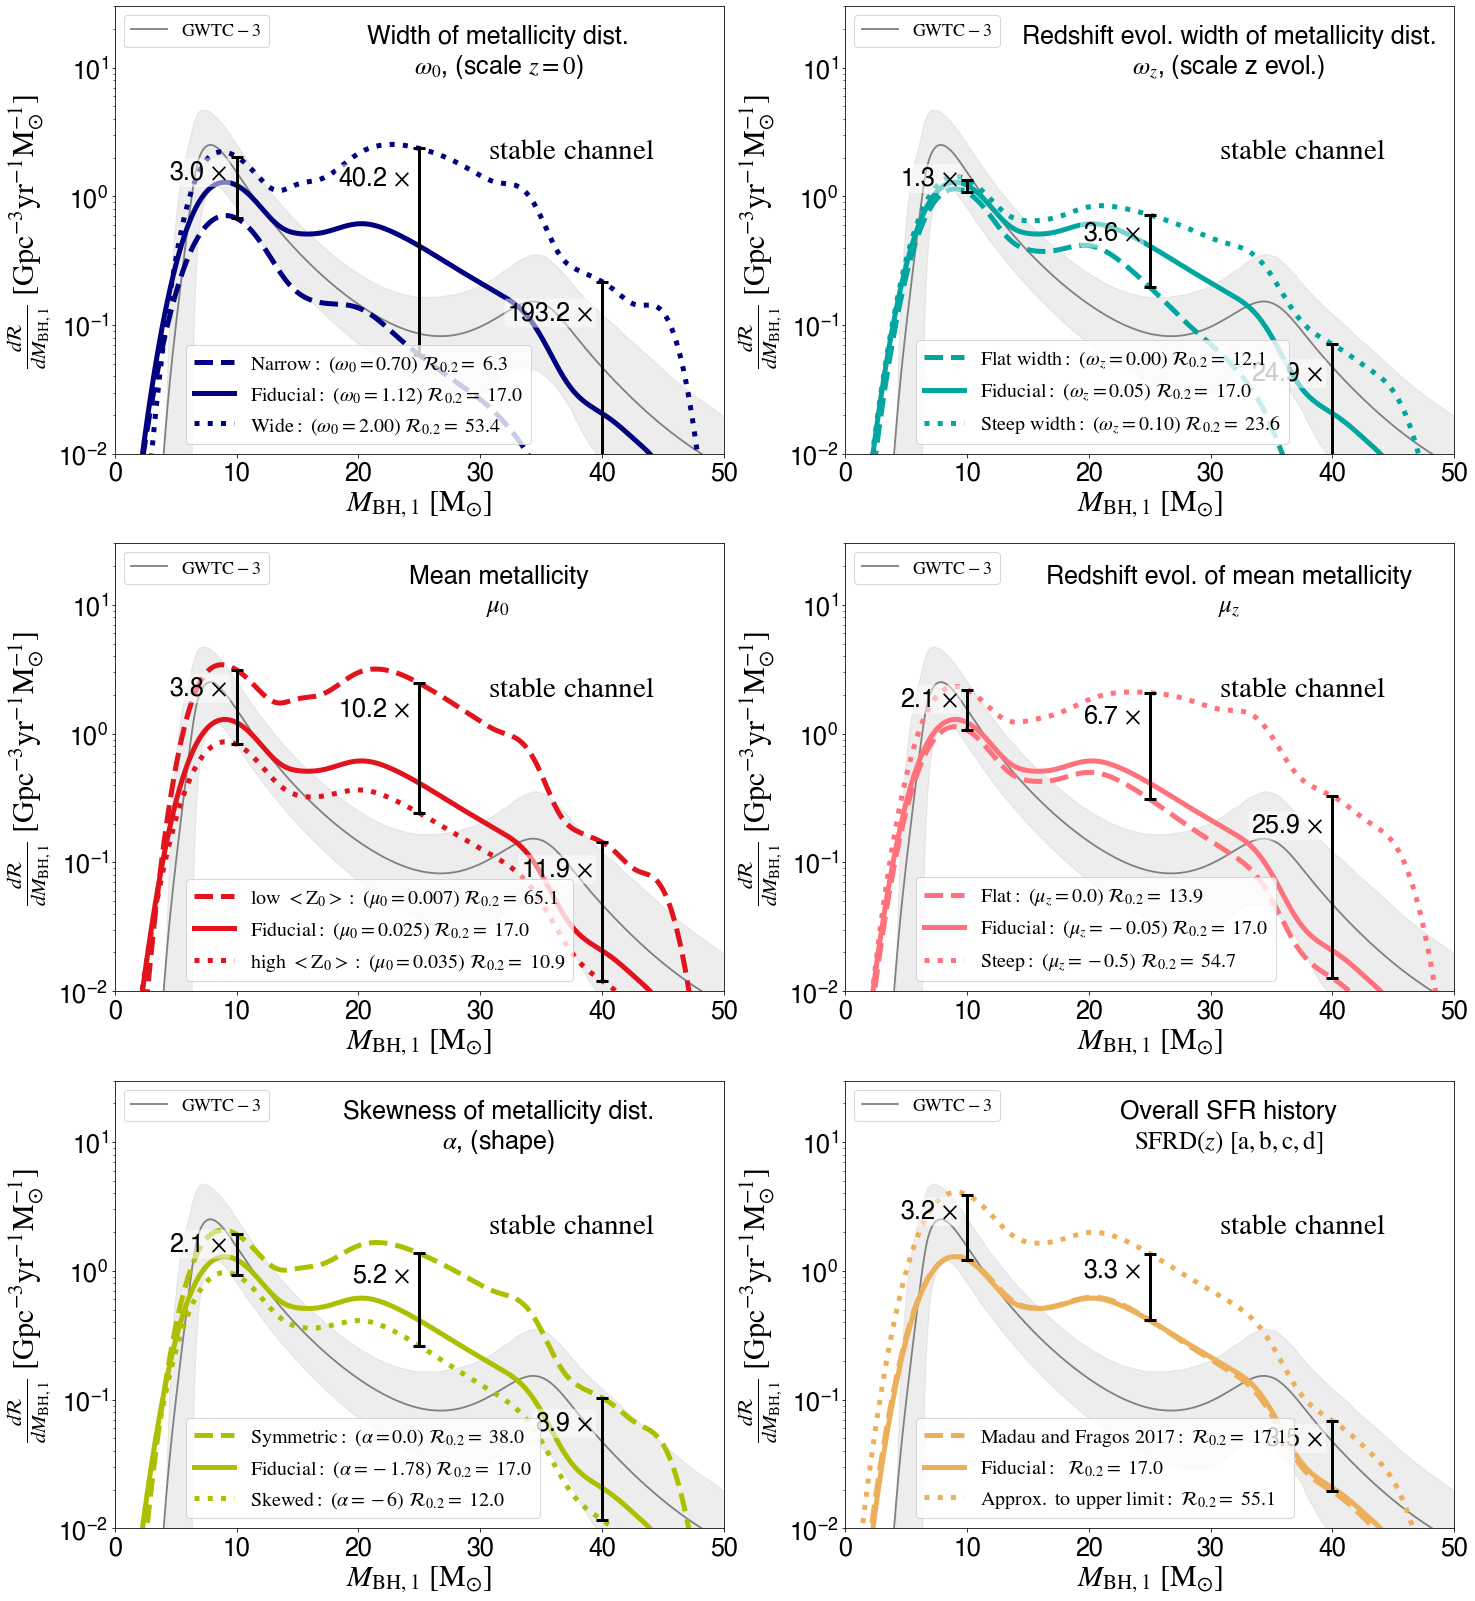

In [18]:
#plotting
fig = plt.figure( figsize = (24, 28))
#figure 3: stable MT, no unstable so no CE
only_stable = True 
only_CE     = False 
channel_string = 'stable'

# width of SFRD at z=0 - sigma0 varied
subplot1 = fig.add_subplot(321) #first subplot in layout that has 3 rows and 2 columns
ax1 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), x, np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.7, np.round(omega0_best, 3), 2.0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                           labels = [r'$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Wide: \ } (\omega_0 = 2.00) \  \mathcal{R}_{0.2} = \ $'],
                           multipanel = True, subplot = subplot1)

# Redshift evolution of the width - sigma z varied
subplot2 = fig.add_subplot(322)
ax2 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), x, np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(omegaz_best, 3), 0.1]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#00a6a0', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf',  titletext = "Redshift evol. width of metallicity dist." +"\n"+ r"$\omega_z$, (scale z evol.)",
                           labels = [r'$\mathrm{Flat \ width: \ } (\omega_z = 0.00) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_z = 0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep \ width: \ } (\omega_z = 0.10) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot2)

# Mean metallicity at z=0 - mu0 varied
subplot3 = fig.add_subplot(323)
ax3 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(x, np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.007, np.round(mu0_best, 3), 0.035]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#e1131d', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf',  titletext = 'Mean metallicity'+"\n"+r"$\mu_0$",
                           labels = [r'$\mathrm{low \ <Z_0> : \ } (\mu_0 = 0.007) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial : \ }  (\mu_0 = 0.025) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{high \ <Z_0> : \ } (\mu_0 = 0.035) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot3)

# Redshift evolution of mean metallicity - mu z varied
subplot4 = fig.add_subplot(324)
ax4 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), x, np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(muz_best, 3), -0.5]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ff717b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', titletext = "Redshift evol. of mean metallicity" +"\n"+ r"$\mu_z$", 
                           labels = [r'$\mathrm{Flat: \ }  (\mu_z = 0.0) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep: \ } (\mu_z = -0.5) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot4)

# Skewness - alpha varied
subplot5 = fig.add_subplot(325)
ax5 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), x, np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(alpha0_best, 3), -6.0]],channel_string = channel_string,
                           show_hist = False, show_KDE = True, plot_LIGO = True, Color = '#acbf00', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Skewness of metallicity dist." +"\n"+ r"$\alpha$, (shape)", 
                           labels = [r'$\mathrm{Symmetric: \ } (\alpha = 0.0)   \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \  } (\alpha = -1.78)  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Skewed: \    } (\alpha = -6)  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot5)

# Star formation norm - SFRD(z) varied
subplot6 = fig.add_subplot(326)
ax6 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  
                           rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.01, 2.6, 3.2, 6.2),
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)), 
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.03, 2.6, 3.3, 5.9)],
                                 channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ecb05b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Overall SFR history"+"\n"+ r'$ \mathrm{SFRD(}z\rm{)} \ [a,b,c,d]$', 
                           labels = [r'$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot6)

fig.savefig(paths.figures /'Massdistribitions_stable_TNG100.pdf', bbox_inches='tight')

plotting LIGO
Reading  /Users/sashalvna/Research/Fit_SFRD_TNG/data//COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
nplot 0 

rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma00.7_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $  len(merging_BBH)= 1187691  Rate =  24.258943174201967  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 1187691  Rate =  41.512204743844826  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma02.0_sigmaz0.05_a0.017_b1.485_c4.

m 2.9571598710381966 [7.8929921] [2.58301232]

m 0.1850206162792017 [0.45590498] [0.14972291]

m 0.0003983916086672465 [0.00110324] [0.00035415]



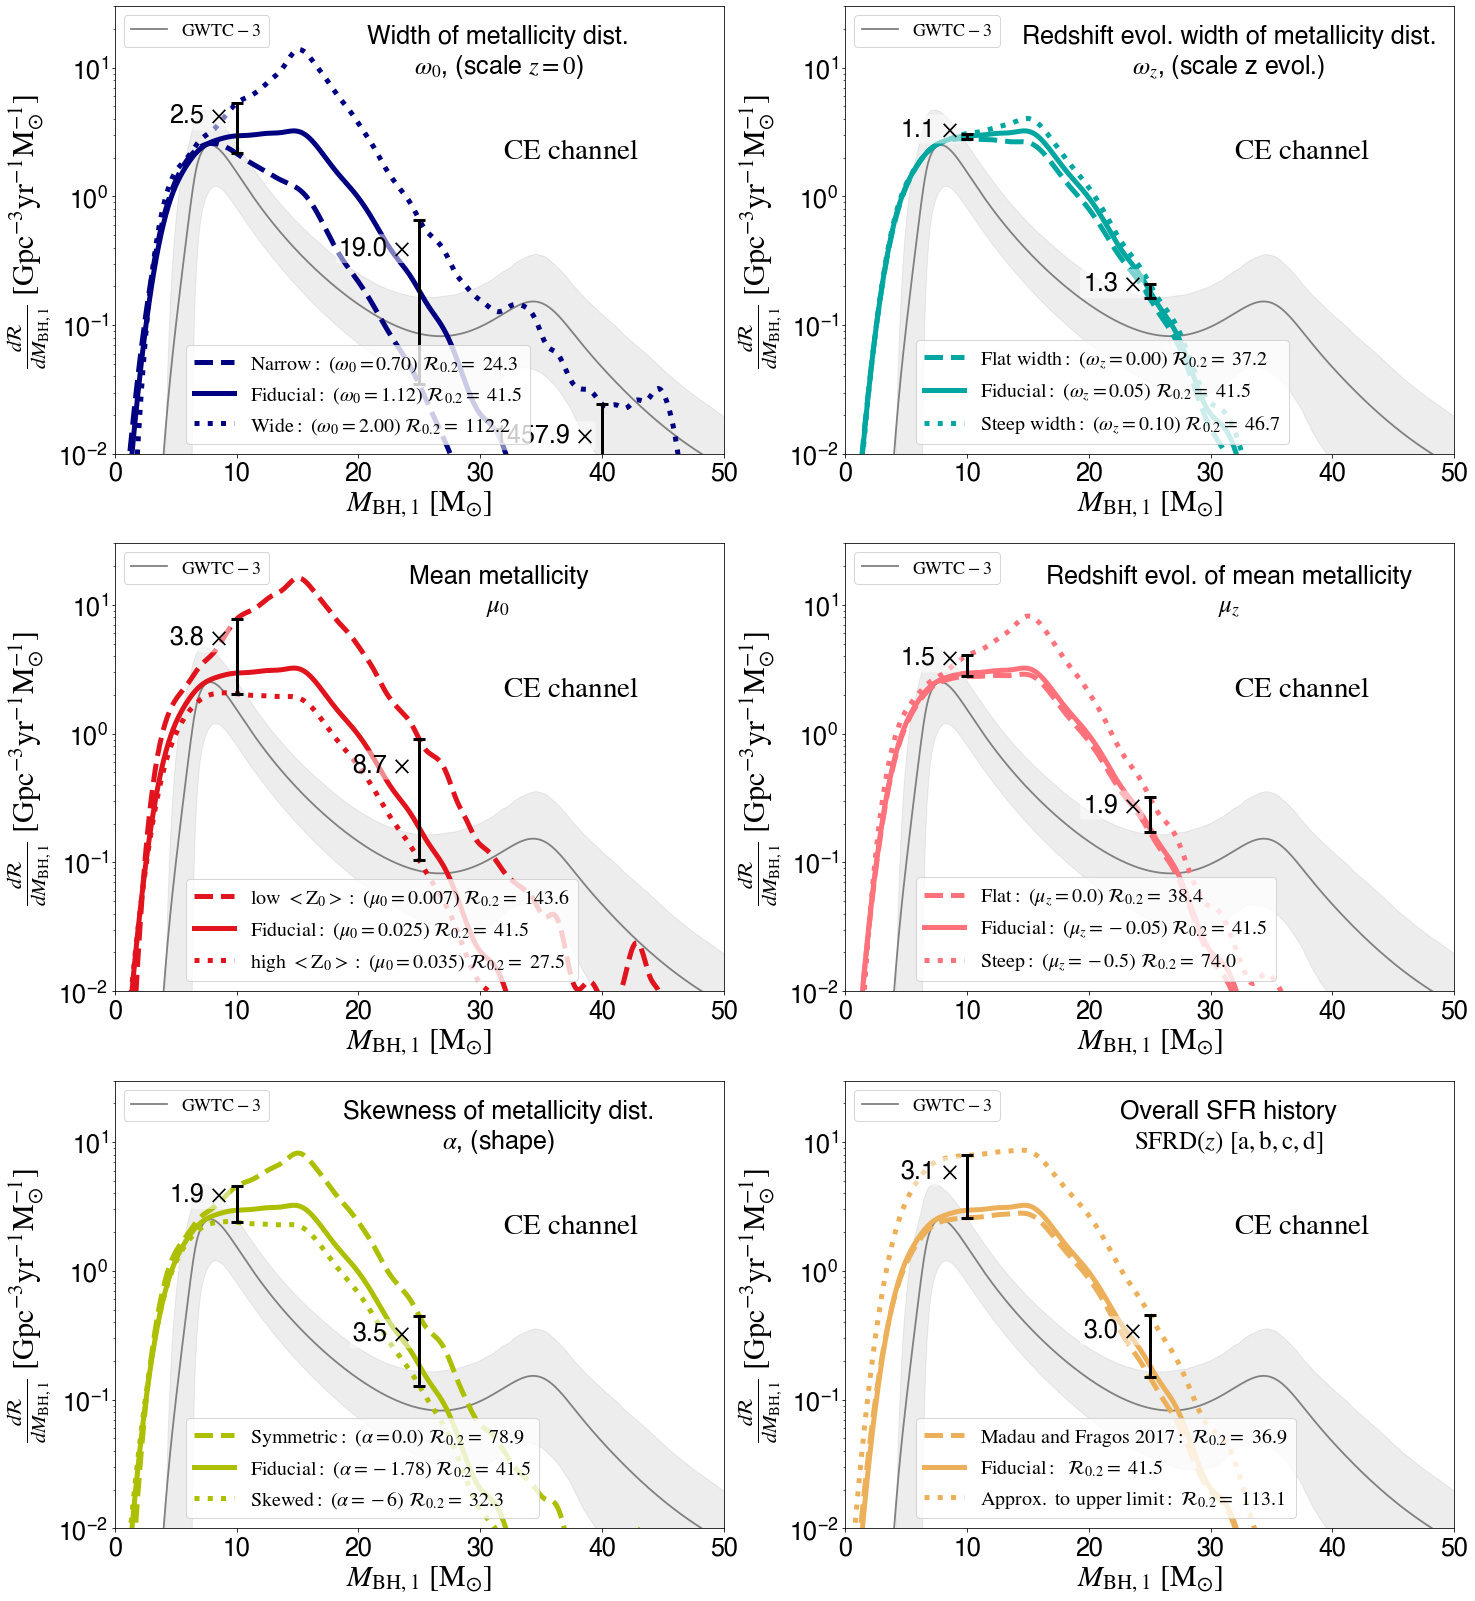

In [19]:
#plotting
fig = plt.figure( figsize = (24, 28))
#figure 4: unstable MT, so CE
only_stable = False 
only_CE     = True 
channel_string = 'CE'

# width of SFRD at z=0 - sigma0 varied
subplot1 = fig.add_subplot(321) #first subplot in layout that has 3 rows and 2 columns
ax1 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), x, np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.7, np.round(omega0_best, 3), 2.0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                           labels = [r'$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Wide: \ } (\omega_0 = 2.00) \  \mathcal{R}_{0.2} = \ $'],
                           multipanel = True, subplot = subplot1)

# Redshift evolution of the width - sigma z varied
subplot2 = fig.add_subplot(322)
ax2 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), x, np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(omegaz_best, 3), 0.1]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#00a6a0', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf',  titletext = "Redshift evol. width of metallicity dist." +"\n"+ r"$\omega_z$, (scale z evol.)",
                           labels = [r'$\mathrm{Flat \ width: \ } (\omega_z = 0.00) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_z = 0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep \ width: \ } (\omega_z = 0.10) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot2)

# Mean metallicity at z=0 - mu0 varied
subplot3 = fig.add_subplot(323)
ax3 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(x, np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.007, np.round(mu0_best, 3), 0.035]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#e1131d', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf',  titletext = 'Mean metallicity'+"\n"+r"$\mu_0$",
                           labels = [r'$\mathrm{low \ <Z_0> : \ } (\mu_0 = 0.007) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial : \ }  (\mu_0 = 0.025) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{high \ <Z_0> : \ } (\mu_0 = 0.035) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot3)

# Redshift evolution of mean metallicity - mu z varied
subplot4 = fig.add_subplot(324)
ax4 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), x, np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(muz_best, 3), -0.5]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ff717b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', titletext = "Redshift evol. of mean metallicity" +"\n"+ r"$\mu_z$", 
                           labels = [r'$\mathrm{Flat: \ }  (\mu_z = 0.0) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep: \ } (\mu_z = -0.5) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot4)

# Skewness - alpha varied
subplot5 = fig.add_subplot(325)
ax5 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), x, np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(alpha0_best, 3), -6.0]],channel_string = channel_string,
                           show_hist = False, show_KDE = True, plot_LIGO = True, Color = '#acbf00', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Skewness of metallicity dist." +"\n"+ r"$\alpha$, (shape)", 
                           labels = [r'$\mathrm{Symmetric: \ } (\alpha = 0.0)   \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \  } (\alpha = -1.78)  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Skewed: \    } (\alpha = -6)  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot5)

# Star formation norm - SFRD(z) varied
subplot6 = fig.add_subplot(326)
ax6 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  
                           rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.01, 2.6, 3.2, 6.2),
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)), 
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.03, 2.6, 3.3, 5.9)],
                                 channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ecb05b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Overall SFR history"+"\n"+ r'$ \mathrm{SFRD(}z\rm{)} \ [a,b,c,d]$', 
                           labels = [r'$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot6)

fig.savefig(paths.figures /'Massdistribitions_CE_TNG100.pdf', bbox_inches='tight')

plotting LIGO
Reading  /Users/sashalvna/Research/Fit_SFRD_TNG/data//COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
nplot 0 

rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma00.7_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned
using file with key CE_Event_Count
Both only_stable and only_CE, I assume you just want both
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $  len(merging_BBH)= 1637144  Rate =  30.59341220792859  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned
using file with key CE_Event_Count
Both only_stable and only_CE, I assume you just want both
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 1637144  Rate =  58.46774251232632 

Both only_stable and only_CE, I assume you just want both
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 1637144  Rate =  54.0043084966577  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.017_b1.485_c4.44_d6.014_zBinned
using file with key CE_Event_Count
Both only_stable and only_CE, I assume you just want both
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 1637144  Rate =  58.46774251232632  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.782_sigma01.12_sigmaz0.05_a0.03_b2.6_c3.3_d5.9_zBinned
using file with key CE_Event_Count
Both only_stable and only_CE, I assume you just want both
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH

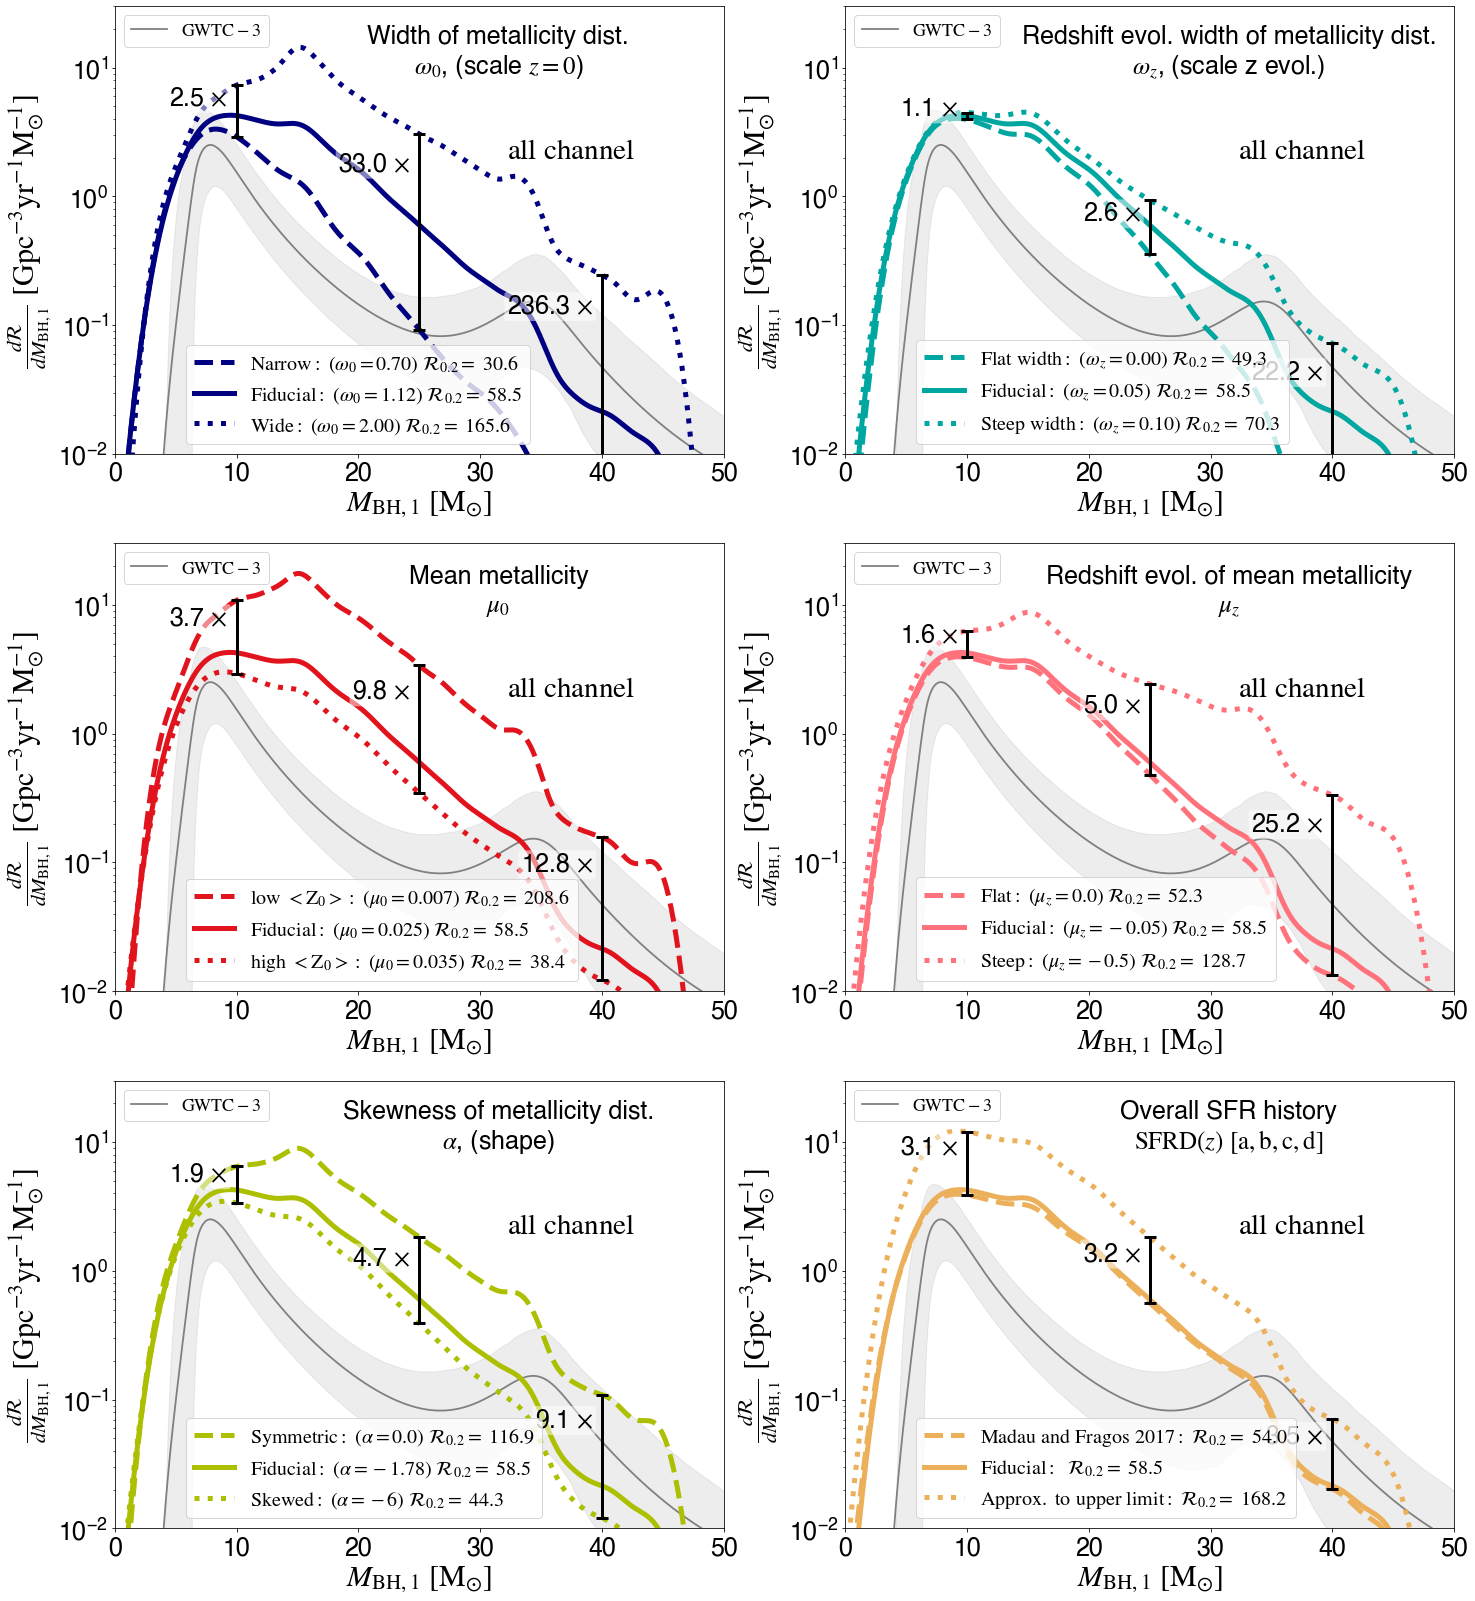

In [20]:
#plotting
fig = plt.figure( figsize = (24, 28))
#figure 4: unstable MT, so CE
only_stable = True 
only_CE     = True 
channel_string = 'all'

# width of SFRD at z=0 - sigma0 varied
subplot1 = fig.add_subplot(321) #first subplot in layout that has 3 rows and 2 columns
ax1 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), x, np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.7, np.round(omega0_best, 3), 2.0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                           labels = [r'$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Wide: \ } (\omega_0 = 2.00) \  \mathcal{R}_{0.2} = \ $'],
                           multipanel = True, subplot = subplot1)

# Redshift evolution of the width - sigma z varied
subplot2 = fig.add_subplot(322)
ax2 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), x, np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(omegaz_best, 3), 0.1]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#00a6a0', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf',  titletext = "Redshift evol. width of metallicity dist." +"\n"+ r"$\omega_z$, (scale z evol.)",
                           labels = [r'$\mathrm{Flat \ width: \ } (\omega_z = 0.00) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_z = 0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep \ width: \ } (\omega_z = 0.10) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot2)

# Mean metallicity at z=0 - mu0 varied
subplot3 = fig.add_subplot(323)
ax3 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(x, np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.007, np.round(mu0_best, 3), 0.035]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#e1131d', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf',  titletext = 'Mean metallicity'+"\n"+r"$\mu_0$",
                           labels = [r'$\mathrm{low \ <Z_0> : \ } (\mu_0 = 0.007) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial : \ }  (\mu_0 = 0.025) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{high \ <Z_0> : \ } (\mu_0 = 0.035) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot3)

# Redshift evolution of mean metallicity - mu z varied
subplot4 = fig.add_subplot(324)
ax4 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), x, np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(muz_best, 3), -0.5]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ff717b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', titletext = "Redshift evol. of mean metallicity" +"\n"+ r"$\mu_z$", 
                           labels = [r'$\mathrm{Flat: \ }  (\mu_z = 0.0) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep: \ } (\mu_z = -0.5) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot4)

# Skewness - alpha varied
subplot5 = fig.add_subplot(325)
ax5 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), x, np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(alpha0_best, 3), -6.0]],channel_string = channel_string,
                           show_hist = False, show_KDE = True, plot_LIGO = True, Color = '#acbf00', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Skewness of metallicity dist." +"\n"+ r"$\alpha$, (shape)", 
                           labels = [r'$\mathrm{Symmetric: \ } (\alpha = 0.0)   \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \  } (\alpha = -1.78)  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Skewed: \    } (\alpha = -6)  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot5)

# Star formation norm - SFRD(z) varied
subplot6 = fig.add_subplot(326)
ax6 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  
                           rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.01, 2.6, 3.2, 6.2),
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)), 
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.03, 2.6, 3.3, 5.9)],
                                 channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ecb05b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Overall SFR history"+"\n"+ r'$ \mathrm{SFRD(}z\rm{)} \ [a,b,c,d]$', 
                           labels = [r'$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot6)

fig.savefig(paths.figures /'Massdistribitions_TNG100.pdf', bbox_inches='tight')

In [31]:
#Plot merger rates

rate_file='/'+str('1_Rate_info_TNG100.h5')
rate_key = 'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3))
with h5.File(data_dir + rate_file ,'r') as File:
    redshifts                 = File[rate_key]['redshifts'][()]
    # Different per rate key:
    DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
    #(contains filter for RLOF>CE and optimistic CE)
    merger_rate    = File[rate_key]['merger_rate'][()]

In [32]:
redshifts

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
       3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
       3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
       4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45,
       5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  ,
       6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55,
       6.6 , 6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 ,
       7.15, 7.2 , 7.25, 7.3 , 7.35, 7.4 , 7.45, 7.

In [33]:
total_merger_rate = np.sum(merger_rate, axis=0)

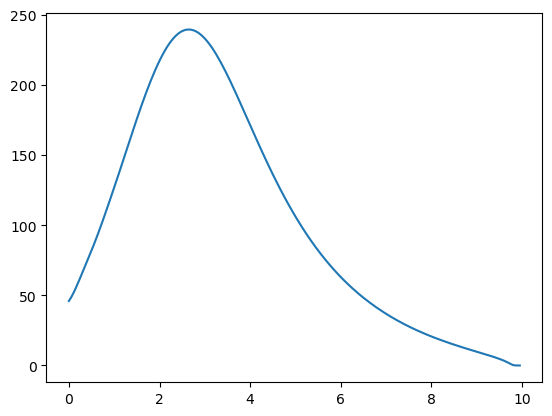

In [36]:
plt.rcdefaults()

plt.plot(redshifts, total_merger_rate)